In [1]:
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from keras_helper import NNWeightHelper
from snes import SNES

import pickle as pkl


Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from numpy import argmax

In [3]:
# use just a small sample of the train set to test
SAMPLE_SIZE = 1024
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 20
# how many times we will loop over ask()/tell()
GENERATIONS = 100

In [4]:
def train_classifier(model, X, y):
    X_features = model.predict(X)
    #clf = ExtraTreesClassifier(n_estimators=100, n_jobs=4)
    clf = DecisionTreeClassifier()

    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred

In [5]:
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)

In [6]:
# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 3)

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

In [9]:
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)


In [10]:
mnist_train_labels = np.zeros((mnist.train.labels.shape[0],), dtype=float)
mnist_test_labels = np.zeros((mnist.test.labels.shape[0],), dtype=float)
for i in range(mnist.train.labels.shape[0]):
    mnist_train_labels[i] = argmax(mnist.train.labels[i])
for i in range(mnist.test.labels.shape[0]):
    mnist_test_labels[i] = argmax(mnist.test.labels[i])

In [11]:
mnist_train_labels.shape, mnist_test_labels.shape

((55000,), (10000,))

In [12]:
mnist_test_labels

array([7., 2., 1., ..., 4., 5., 6.])

In [13]:
train_num = 30000
test_num = 5000

In [14]:
#x_train = np.vstack([mnist_train[:train_num], mnistm_train[:train_num]])
#y_train = np.append(mnist_train_labels[:train_num], mnist_train_labels[:train_num])
x_train = mnist_train
y_train = mnist_train_labels

In [15]:
x_test = mnistm_test
y_test = mnist_test_labels

In [16]:
x_train[0].shape

(28, 28, 3)

In [17]:
mnist_test.shape

(10000, 28, 28, 3)

In [18]:
x_train.shape

(55000, 28, 28, 3)

In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [20]:
len(set(y_train))

10

In [21]:
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (55000, 28, 28, 3)
y_train shape: (55000,)
55000 train samples
10000 test samples


In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))

# this is irrelevant for what we want to achieve
model.compile(loss="mse", optimizer="adam")
print("compilation is over")

compilation is over


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 63,946
Trainable params: 63,946
Non-trainable params: 0
_________________________________________________________________


In [24]:
nnw = NNWeightHelper(model)
weights = nnw.get_weights()


In [25]:
print("Total number of weights to evolve is:", weights.shape)

all_examples_indices = list(range(x_train.shape[0]))

clf, _ = train_classifier(model, x_train, y_train)

y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)

print('Non-trained NN Test accuracy:', test_accuracy)
# print('Test MSE:', test_mse)

snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        # clf, _ = train_classifier(model, x_train, y_train)
        # y_pred = predict_classifier(model, clf, x_test)
        # score = accuracy_score(y_test, y_pred)
            
        # append to array of values that are to be returned
        told.append(score)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)

nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)

print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy:', test_accuracy)



Total number of weights to evolve is: (63946,)
(10000,) (10000,)
Non-trained NN Test accuracy: 0.1768
Step 1.0 : 0.4253658536585366 best: 0.4253658536585366 20
It took 3.867599116958722 seconds to complete generation 1
Step 2.0 : 0.4634146341463415 best: 0.4634146341463415 20
It took 3.8617150722251283 seconds to complete generation 2
Step 3.0 : 0.44097560975609756 best: 0.4634146341463415 20
It took 3.8253733725444956 seconds to complete generation 3
Step 4.0 : 0.47317073170731705 best: 0.47317073170731705 20
It took 3.8795667124411146 seconds to complete generation 4
Step 5.0 : 0.455609756097561 best: 0.47317073170731705 20
It took 3.7426854378781744 seconds to complete generation 5
Step 6.0 : 0.455609756097561 best: 0.47317073170731705 20
It took 3.7772572624140146 seconds to complete generation 6
Step 7.0 : 0.4478048780487805 best: 0.47317073170731705 20
It took 3.805366277241461 seconds to complete generation 7
Step 8.0 : 0.4790243902439024 best: 0.4790243902439024 20
It took 3.81

Step 69.0 : 0.7239024390243902 best: 0.7239024390243902 20
It took 3.8593770987637868 seconds to complete generation 69
Step 70.0 : 0.7180487804878048 best: 0.7239024390243902 20
It took 3.8845816220589313 seconds to complete generation 70
Step 71.0 : 0.7239024390243902 best: 0.7239024390243902 20
It took 3.7486172850431103 seconds to complete generation 71
Step 72.0 : 0.713170731707317 best: 0.7239024390243902 20
It took 3.701742457882517 seconds to complete generation 72
Step 73.0 : 0.7141463414634146 best: 0.7239024390243902 20
It took 3.8157437505234384 seconds to complete generation 73
Step 74.0 : 0.7404878048780488 best: 0.7404878048780488 20
It took 3.8978920312951573 seconds to complete generation 74
Step 75.0 : 0.7053658536585365 best: 0.7404878048780488 20
It took 3.9002896590303635 seconds to complete generation 75
Step 76.0 : 0.744390243902439 best: 0.744390243902439 20
It took 3.9529643828429926 seconds to complete generation 76
Step 77.0 : 0.7121951219512195 best: 0.74439

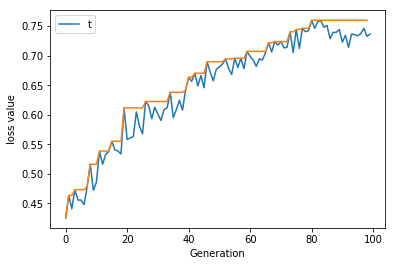

In [26]:
maxline = []
for i in range(1, len(log)):
    maxline.append(max(log[:i]))
plt.plot(log)
plt.xlabel('Generation')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.plot(maxline)
plt.savefig('mnistm_1.png')
plt.show()